In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm
import os
import re
import sys
import time
import logging
import tempfile
from collections import Counter
from typing import List, Tuple
from tqdm import tqdm

import numpy as np
import pandas as pd

import rdkit
from rdkit import Chem
from rdkit.Chem import MolFromSmiles, MolToSmiles, CanonSmiles

In [2]:
import pandas as pd
data = pd.read_csv('smile_3.csv')

smiles = data['canonical_smiles']
#print(len(smiles))

text = str(smiles)
print(len(text))
print(text)

chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode('CCO'))
print(decode(encode('CCO')))

2949
0     CC(C)CN(Sc1ccc2c(c1)CCO2)[C@H](CO)CCCCNC(=O)[C...
1     CC(C)CN(Sc1ccc2c(c1)OCCO2)[C@H](CO)CCCCNC(=O)[...
2     CC(C)CN([C@H](CO)CCCCNC(=O)[C@H](Cc1ccccc1Br)N...
3     Cc1c(O)cccc1C(=O)N[C@@H](Cc1ccccc1Br)C(=O)NCCC...
4     CC(C)CN([C@H](CO)CCCCNC(=O)[C@H](Cc1ccccc1Br)N...
5     Cc1ccccc1C[C@H](NC(=O)c1cccnc1)C(=O)NCCCC[C@@H...
6                O=C(O)CNC(=O)c1c(=O)oc(O)c2cc(Br)ccc12
7     C[C@H](NC(=O)c1c(=O)oc(O)c2cccc(-c3cccc(C(F)(F...
8     Cc1ccccc1C[C@H](NC(=O)c1cccc(C)c1O)C(=O)NCCCC[...
9     COC(=O)N[C@@H](CC1CCCCC1)C(=O)NCCCC[C@@H](CO)N...
10    CC(C)CN([C@H](CO)CCCCNC(=O)[C@H](CC1CCCCC1)NC(...
11    Cc1ccc(C(=O)N[C@@H](CC2CCCCC2)C(=O)NCCCC[C@@H]...
12    COC(=O)N[C@H](C(=O)NCCCC[C@H](CO)N(CC(C)C)S(=O...
13    CC(C)CN([C@H](CO)CCCCNC(=O)[C@H](Cc1ccccc1Cl)N...
14    Cc1ncccc1C(=O)N[C@@H](Cc1ccccc1Cl)C(=O)NCCCC[C...
15    CC(C)CN([C@H](CO)CCCCNC(=O)[C@H](CC1=C(Br)CCC=...
16    COC(=O)N[C@H](C(=O)NCCCC[C@@H](CO)N(CC(C)C)S(=...
17    CC(C)CN([C@H](CO)CCCCNC(=O)[C@@H](NC(

In [6]:
def separate(s):
    stack = []
    sections = []
    for i, c in enumerate(s):
        if c in ['(', '[']:
            stack.append((c, i))
        elif c in [')', ']']:
            while stack:
                opening, start = stack[-1]  # Peek at the top of the stack
                if (opening == '(' and c == ')') or (opening == '[' and c == ']'):
                    stack.pop()  # Remove the matching opening bracket
                    sections.append((start, i))
                    break
                else:
                    stack.pop()  # Remove the non-matching opening bracket

    # Filter out overlapping sections
    non_overlapping_sections = []
    last_end = -1
    for start, end in sorted(sections, key=lambda x: x[0]):
        if start > last_end:
            non_overlapping_sections.append((start, end))
            last_end = end

    return non_overlapping_sections


def show_sections(s, sections):
    all_sections = []
    last_end = 0  # To keep track of the last section's end index

    for start, end in sections:
        if start > last_end:
            # Add the section between the last end and this start
            all_sections.append(s[last_end:start])
        # Add the section within the current parenthesis/bracket
        all_sections.append(s[start:end+1])
        last_end = end + 1  # Update the last end index

    # Handle any remaining section after the last parenthesis/bracket
    if last_end < len(s):
        all_sections.append(s[last_end:])

    return all_sections

s = smiles[0]
sections = separate(s)
all_sections = show_sections(s, sections)
" ".join(all_sections)

'CC (C) CN (Sc1ccc2c(c1)CCO2) [C@H] (CO) CCCCNC (=O) [C@@H] (Cc1cccc2ccccc12) NC (=O) N1CCOCC1'

In [7]:
text = ""

for s in smiles:
    sections = separate(s)
    all_sections = show_sections(s, sections)
    text += " ".join(all_sections)
    text += "*"

In [8]:
print(text)

CC (C) CN (Sc1ccc2c(c1)CCO2) [C@H] (CO) CCCCNC (=O) [C@@H] (Cc1cccc2ccccc12) NC (=O) N1CCOCC1*CC (C) CN (Sc1ccc2c(c1)OCCO2) [C@H] (CO) CCCCNC (=O) [C@@H] (Cc1cccc2ccccc12) NC (=O) N1CCOCC1*CC (C) CN ([C@H](CO)CCCCNC(=O)[C@H](Cc1ccccc1Br)NC(=O)N1CCOCC1) S (=O) (=O) c1ccc2c (c1) CCO2*Cc1c (O) cccc1C (=O) N [C@@H] (Cc1ccccc1Br) C (=O) NCCCC [C@@H] (CO) N (CC(C)C) S (=O) (=O) c1ccc (N) cc1*CC (C) CN ([C@H](CO)CCCCNC(=O)[C@H](Cc1ccccc1Br)NC(=O)c1cccc(=O)[nH]1) S (=O) (=O) c1ccc (N) cc1*Cc1ccccc1C [C@H] (NC(=O)c1cccnc1) C (=O) NCCCC [C@@H] (CO) N (CC(C)C) S (=O) (=O) c1ccc (N) cc1*O=C (O) CNC (=O) c1c (=O) oc (O) c2cc (Br) ccc12*C [C@H] (NC(=O)c1c(=O)oc(O)c2cccc(-c3cccc(C(F)(F)F)c3)c12) C (=O) O*Cc1ccccc1C [C@H] (NC(=O)c1cccc(C)c1O) C (=O) NCCCC [C@@H] (CO) N (CC(C)C) S (=O) (=O) c1ccc (N) cc1*COC (=O) N [C@@H] (CC1CCCCC1) C (=O) NCCCC [C@@H] (CO) N (CC(C)C) S (=O) (=O) c1ccc (N) cc1*CC (C) CN ([C@H](CO)CCCCNC(=O)[C@H](CC1CCCCC1)NC(=O)c1cccnc1) S (=O) (=O) c1ccc (N) cc1*Cc1ccc (C(=O)N[C@@H](

In [11]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 1000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)


# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


0.204698 M parameters


In [12]:


train_losses = []
val_losses = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)


step 0: train loss 3.3736, val loss 3.3552
step 10: train loss 2.1690, val loss 2.4574
step 20: train loss 1.8075, val loss 2.3229
step 30: train loss 1.6200, val loss 2.2112
step 40: train loss 1.4788, val loss 2.2053
step 50: train loss 1.4075, val loss 2.1625
step 60: train loss 1.3609, val loss 2.1767
step 70: train loss 1.3185, val loss 2.1884
step 80: train loss 1.2840, val loss 2.1911
step 90: train loss 1.2434, val loss 2.1813
step 100: train loss 1.2038, val loss 2.0821
step 110: train loss 1.1664, val loss 2.1193
step 120: train loss 1.1306, val loss 2.0861
step 130: train loss 1.1053, val loss 2.1346
step 140: train loss 1.0882, val loss 2.0960
step 150: train loss 1.0401, val loss 2.1478
step 160: train loss 1.0186, val loss 2.1212
step 170: train loss 0.9757, val loss 2.1476
step 180: train loss 0.9513, val loss 2.1006
step 190: train loss 0.9330, val loss 2.1096
step 200: train loss 0.8978, val loss 2.1072
step 210: train loss 0.8870, val loss 2.1398
step 220: train loss 

KeyboardInterrupt: 

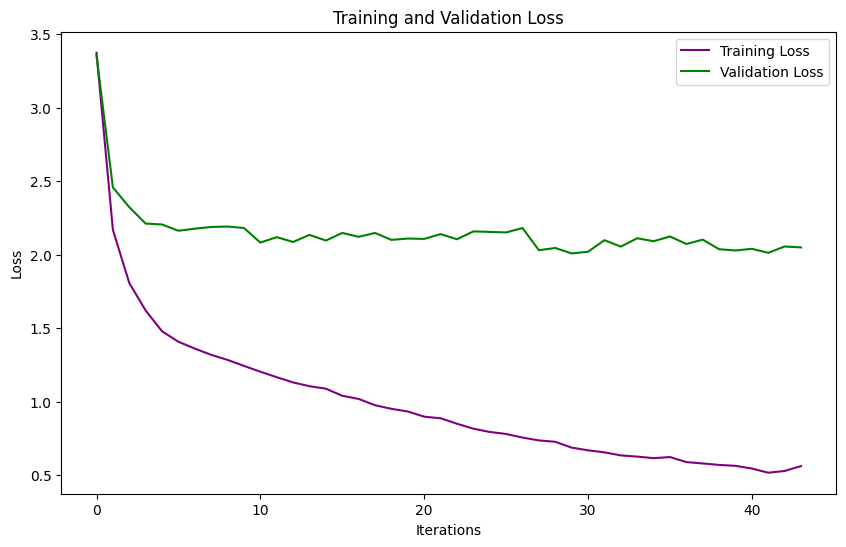

In [13]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='purple')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [14]:
val = decode(m.generate(context, max_new_tokens=2000)[0].tolist())

NameError: name 'context' is not defined

In [15]:
model_state_path = "basic_B.pkl"
torch.save(model.state_dict(), model_state_path)

print("Model saved successfully.")

Model saved successfully.
